# The Problem with ANPR datasets.
- Hard to find ANPR dataset due to legality issues.
- Difficult to find high quality license platte images that contain both.
    - A full visible view of the license plate.
    - Labeled license plate characters.
    
## ANPR Datasets
- CALTECH 2001 (rear)
- CALTECH 199 (rear) 2
- Oxford VGG Car datasets
- Medialab: The dataset that is used in the course

# Localizing(find) license plates in images
- Four steps in ANPR:
     - Photo acquisition: Using Medialab
     - Localizing the license plate:
     - Segmentation of characters from license plate.
     - Recognition of characters.
- Find the regions of an image that potentially contain license platees. We call these regions "license plate candidates"
- Two methods:
    - Utilizing machine learning: Requires a large dataset of license plate images with bounding boxes pre-cropped so you can train clssifier what a lciense plate looks like. Complex, requires lot of data, and very time consuming to build.
    - Contours and morphological operations.

## Objectives:
- Apply morpho operations to reveal regions that could contain a license plate.
- Utilize contour properties to prune our license plate candidates leaving only regions of image that are highly likely to contain a license plate.

## Localizing license plates in images
- We can use the following properties to localise the plate:
     - The license plate is always darker than the license plate background
     - The license plate itself is appx a rectangle
     - The plate region is wider than it is tall.

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import cv2
import imutils
from imutils import paths
from cv_imshow import display_image, create_subplot
from matplotlib import pyplot as plt

In [3]:
args = {
    "images":"../images/testing_lp_dataset"
}

In [4]:
class LicensePlateDetector:
    def __init__(self, image, minPlateW=60, minPlateH=20):
        self.image = image 
        self.minPlateW = minPlateW
        self.minPlateH = minPlateH
     
    #handles detecting license plate regions, 
    #segmenting the plate from rest of image
    #extract individual char from plate
    #for now, only we use this only for detecting license plate regions
    def detect(self):
        #detect and return license plate regions in the image
        return self.detectPlates()
    
    def detectPlates(self):
        fig = plt.figure(figsize=(20, 30))
        rows = 5
        columns = 3
        
        #init the rect(for license plate) and sqare kernels
        #square kernel is used to close gaps using close op.
        #init list of potential license plate regions
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,5))
        squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        regions = []
        
        #convert image to grayscale and apply blackhat operation
        #reveaals dark text of license plate chars against light bg
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
        create_subplot(fig, rows, columns, 1,"Step1: Gray", gray)
        create_subplot(fig, rows, columns, 2,"Step2: blackHat", blackHat)
        
        #find regions in image that are light
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKernel)
        create_subplot(fig, rows, columns, 3, "Inter Step: Close Gray", light)
        
        light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]
        create_subplot(fig, rows, columns, 4,"Inter Step: Thresh Closed Gray", light)
        
        # compute the Scharr gradient representation of the blackhat image
        # in x-direction and scale the resulting image into range [0,255]
        gradX = cv2.Sobel(blackHat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        create_subplot(fig, rows, columns, 5,"Step 3: gradX using sobel", gradX)
        
        gradX = np.absolute(gradX)
        create_subplot(fig, rows, columns, 6,"Step 4: gradX absolute", gradX)
        
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = (255*((gradX-minVal)/(maxVal-minVal))).astype("uint8")
        create_subplot(fig, rows, columns, 7,"Step 5: min and max gradX", gradX)
        
        #blur the gradient representation, apply a closing operation and threshold
        #image using Otsu's method
        gradX = cv2.GaussianBlur(gradX, (5,5), 0)
        create_subplot(fig, rows, columns, 8,"Step 6: Gaussian Blurred gradX", gradX)
        
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
        create_subplot(fig, rows, columns, 9,"Step 7: MorphoEx Close GradX", gradX)
        
        thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
        create_subplot(fig, rows, columns, 10,"Step 8: Final Thresholded gradX", thresh)
        
        #perform a serie of erosions and dilations on image.
        thresh = cv2.erode(thresh, None, iterations=2)
        create_subplot(fig, rows, columns, 11,"Step 9: Erode threshold", gradX)
        
        thresh = cv2.dilate(thresh, None, iterations=2)
        create_subplot(fig, rows, columns, 12,"Step 10: Dilate threshold", gradX)
        
        # take the bitwise 'and' between the 'light' regions of the image, then perform
        # another series of erosions and dilations
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        create_subplot(fig, rows, columns, 13,"Step 11: Bitwise and light and thresh", gradX)
        
        thresh = cv2.dilate(thresh, None, iterations=2)
        create_subplot(fig, rows, columns, 14,"Step 12: Dilate threshold", gradX)
        
        thresh = cv2.erode(thresh, None, iterations=1)
        create_subplot(fig, rows, columns, 15,"Step 13: Erode threshold", gradX)
        
        #find contours in thresh image
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        for c in cnts:
            #get bounding box associated with contour and compute area and aspect ratio
            (w, h) = cv2.boundingRect(c)[2:]
            aspectRatio = w/float(h)
            
            #compute rotated bounding box of the region
            rect = cv2.minAreaRect(c)
            box = np.int0(cv2.boxPoints(rect))
            
            #ensure aspect ratio, w, h of bounding box falls within tolerable limits
            #update list of license plate regions
            if (aspectRatio>3 and aspectRatio<6) and h>self.minPlateH and w>self.minPlateW:
                regions.append([aspectRatio, w, h, box])
               
        return regions

# Localization in action

../images/testing_lp_dataset/0q9ok.jpg


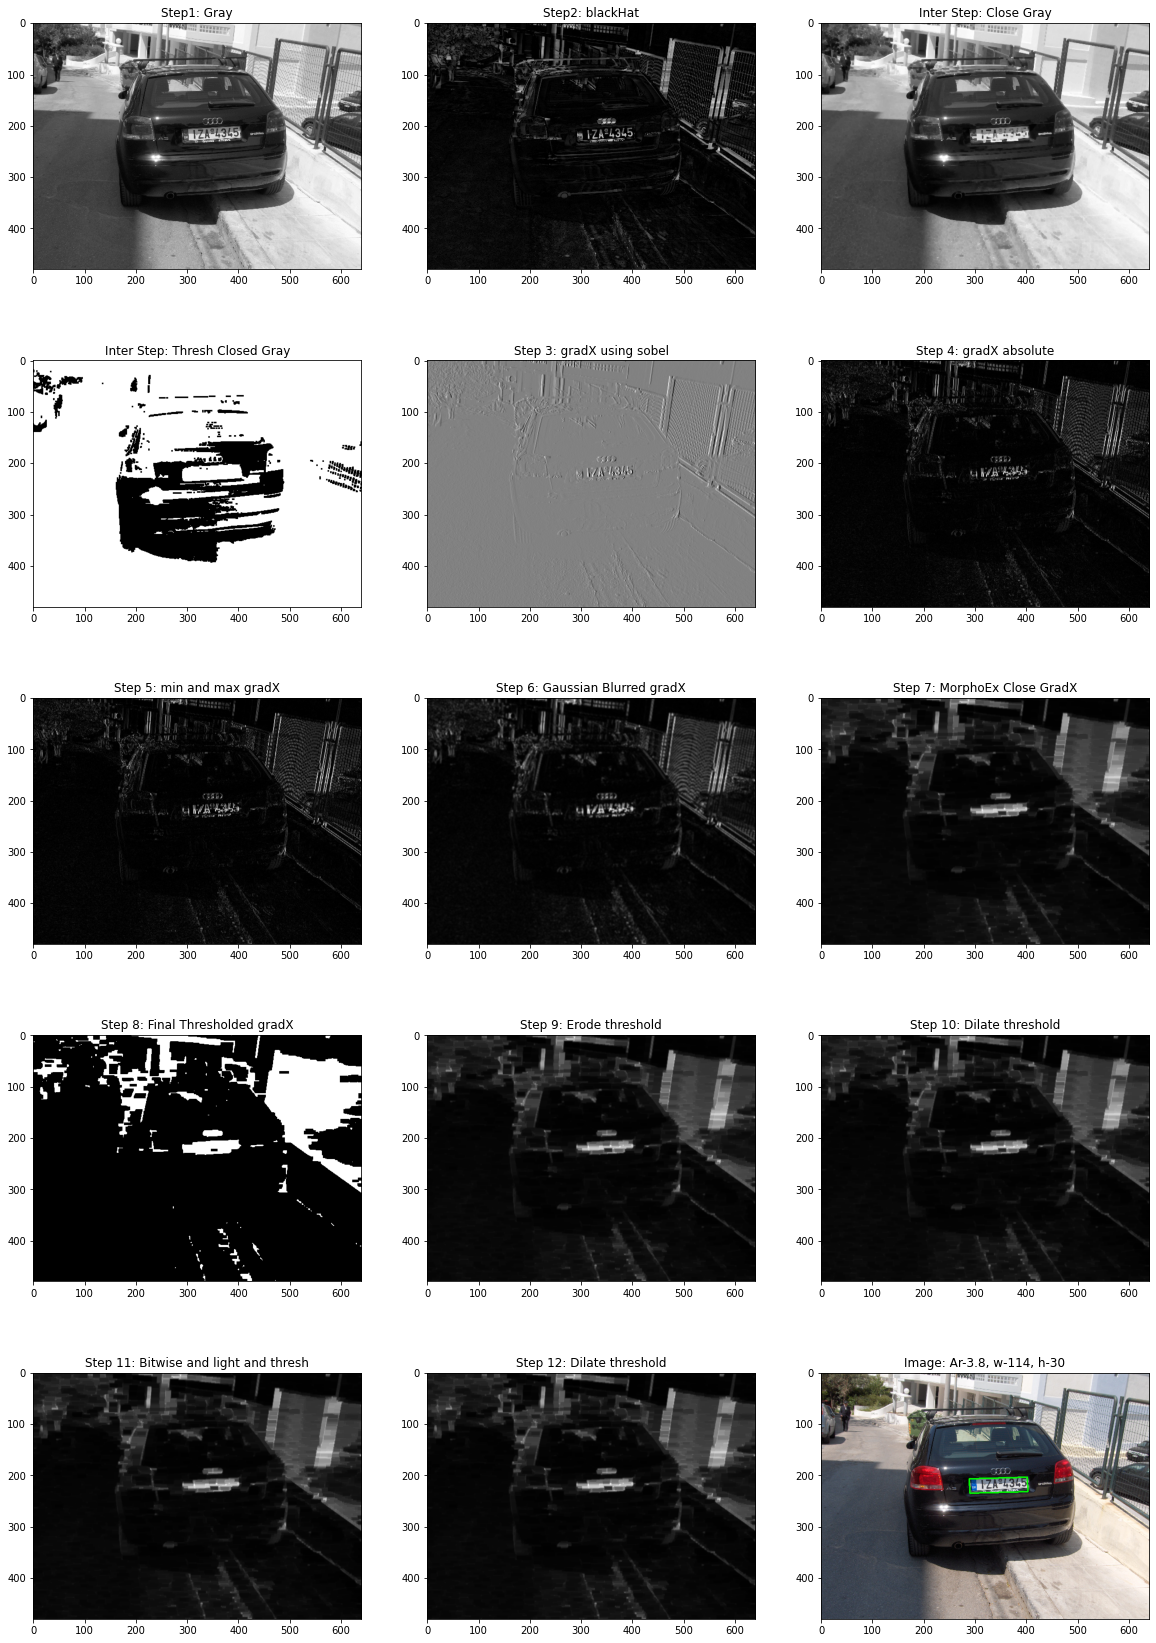

In [5]:
for imagePath in sorted(list(paths.list_images(args["images"]))):
    #load image
    image = cv2.imread(imagePath)
    print(imagePath)
    
    #if width > 640p, resize
    if image.shape[1] > 640:
        image = imutils.resize(image, width=640)
    
    #init license plate detector and detect license plate and chars
    lpd = LicensePlateDetector(image)
    regions = lpd.detect()
    
    #loop over license plate regions and draw bounding box 
    for lpBox in regions:
        aspectRatio = lpBox[0]
        w = lpBox[1]
        h = lpBox[2]
        box = lpBox[3]
        box = np.array(box).reshape((-1, 1, 2)).astype(np.int32)
        cv2.drawContours(image, [box], -1, (0,255,0),2)
        display_image("Image: Ar-{}, w-{}, h-{}".format(aspectRatio, w, h), image)
    break